# Portfolio Optimization using Modern Portfolio Theory

We all know that 'High risk, high return' is a no-brainer concept in finance. You potentailly earn more if you are willing to take on more risk but for a given level of risk, how do we ensure that we maximise return?

To answer that question, in 1950s, Henry Markowitz propose Modern Portfolio Theory (MPT), a mean-variabce analysis which help investors construct maximize expected return based on a given level of market risk. He was later awarded a Nobel Prize for that theory. 

Of course, Modern Portfolio Theory is not a bullet-proof approach when it comes to investing. Some crtique that the approach lacks value investing perspectives. After all one should be more concerned with industry trends, company performance and strategic directions rather than past returns as historical performance may not be representative of future result. 

However, I am of the opinion that once all value investing analysis have been conducted and an investor have alredy shortlisted a list of prefered stocks, how does he/she best allocate the resource for the selected stocks? 

In this jupyter notebook, I created a simple tool for users to input a list of stocks they are interested in, and the tool will suggest optimal allocations based on risks and returns. 

## Part0: Inputs


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
import quandl
%matplotlib inline

In [4]:
quandl.ApiConfig.api_key = "bbrmzSpfns9HonV1xx5u"

In order to come up with the optimal allocation, we need two main important inputs:

<ul> 
    <li> A list of prefered stocks
    <li> Time period to extract historical data

</ul> 

For this analysis, let's assume we are interested in 5 stocks: Microsoft (MSFT), Walmart (WMT), Johnson & Johnson (JNJ), Intel (INTC) and JPMorgan Chase & Co. (JPM). Looks like we are having a very diversified portfolio. 

Also, we are going to base our portfolio allocation based on 5 years historical data from 2013 to 2018. 



In [8]:
#INPUTS

#specify stocks of interest

stocks_of_interest= ['MSFT','WMT','JNJ','INTC','JPM']

#specify study window
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2018-01-01')


# Part 1: Data Extraction and Exploration 

Next, let's extract the stock price usinga very useful tool, quandl. 

In [9]:
#get the stock closing price by each day

stocks = quandl.get(('WIKI/{stock}.11'.format(stock=stocks_of_interest[0])),start_date=start,end_date=end)
for i in range(1,len(stocks_of_interest)):
    stock = quandl.get(('WIKI/{stock}.11'.format(stock=stocks_of_interest[i])),start_date=start,end_date=end)
    stocks = pd.concat([stocks,stock],axis=1)
stocks.columns= stocks_of_interest
stocks.head()

,MSFT,WMT,JNJ,INTC,JPM
Date,,,,,
2013-01-02,24.194478,61.097979,61.595109,18.101359,39.388479
2013-01-03,23.870367,60.709719,61.508159,18.050560,39.309103
2013-01-04,23.423618,60.939145,62.212451,17.915096,40.005853
2013-01-07,23.379820,60.356755,62.082027,17.991295,40.049952
2013-01-08,23.257183,60.524413,62.090722,17.855831,40.129328


We can visualize the return for each stocks as follow. 

Cumulative Daily return of each stocks


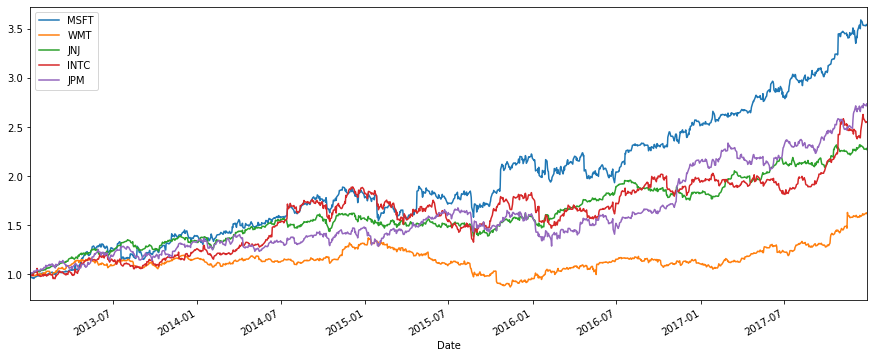

In [10]:
#cumulative daily return
stock_normed = stocks/stocks.iloc[0]
print('Cumulative Daily return of each stocks')
stock_normed.plot(figsize=(15,6))

To get more detail information of the stock, we can use stock calculation function from ffn. 

In [11]:
import ffn
np.seterr(all='ignore')
stats = stocks.calc_stats()
stats.display()

Stat                 MSFT        WMT         JNJ         INTC        JPM
-------------------  ----------  ----------  ----------  ----------  ----------
Start                2013-01-02  2013-01-02  2013-01-02  2013-01-02  2013-01-02
End                  2017-12-29  2017-12-29  2017-12-29  2017-12-29  2017-12-29
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         253.55%     61.63%      126.84%     155.01%     171.50%
Daily Sharpe         1.25        0.65        1.26        0.98        1.09
Daily Sortino        2.11        1.08        2.17        1.65        1.87
CAGR                 28.81%      10.10%      17.84%      20.64%      22.17%
Max Drawdown         -18.05%     -36.44%     -14.53%     -29.75%     -23.20%
Calmar Ratio         1.60        0.28        1.23        0.69        0.96

MTD                  1.63%       1.56%       0.28%       2.94%       2.32%
3m                   15.42%      26.38%      8.12%       22.64%      12.61%
6m     

Let's visualize what the logarith return looks like for each stock. 

Annualized return for each stock
MSFT    0.253175
WMT     0.096252
JNJ     0.164203
INTC    0.187364
JPM     0.200236
dtype: float64


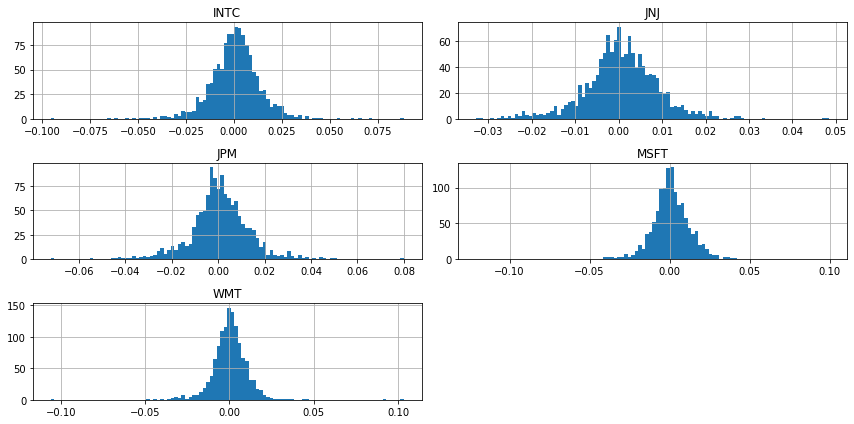

In [12]:
#logarith return of the stock
log_return = np.log(stocks/stocks.shift(1))
log_return.hist(bins=100,figsize=(12,6));

print('Annualized return for each stock')
print(log_return.mean() * 252)
plt.tight_layout()

Box Plot for each stock return


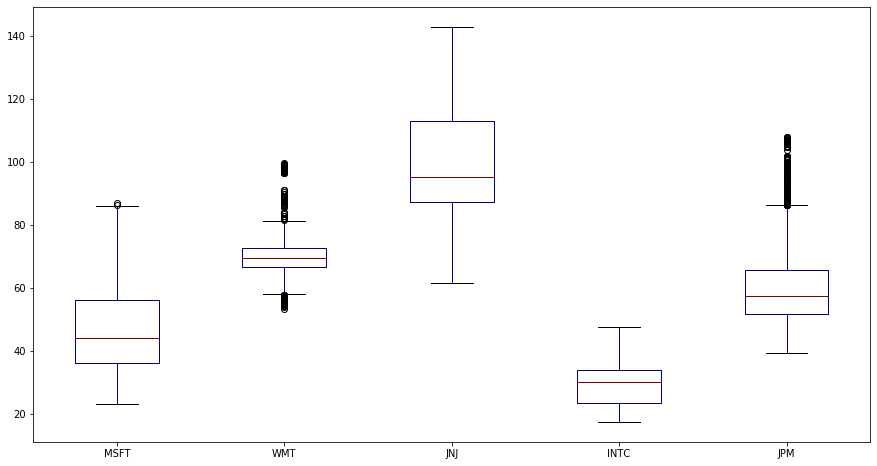

In [13]:
print("Box Plot for each stock return")
stocks.plot(kind='box',figsize=(15,8),colormap='jet')

Let's find out if there are any strong correlation between any pair of the stocks. 

Correlation between each stock in portfolio


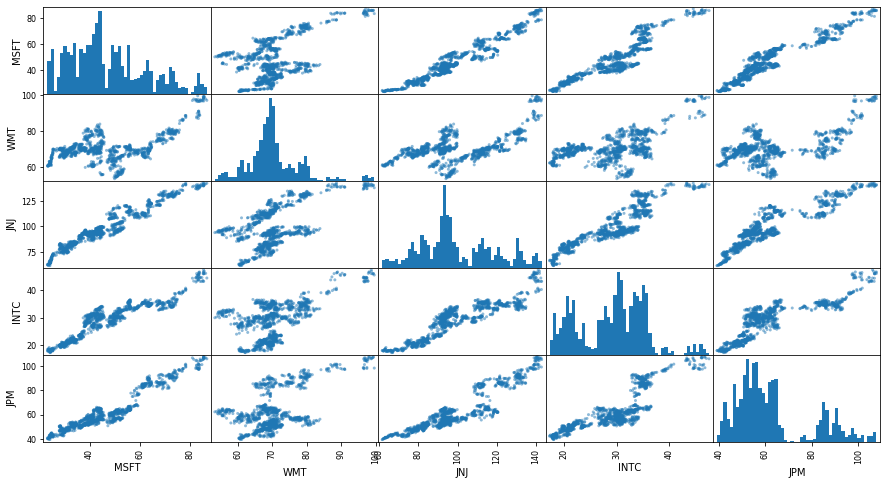

In [14]:
print("Correlation between each stock in portfolio")
scatter_matrix(stocks,figsize=(15,8),alpha=0.5,hist_kwds={'bins':50});

In [15]:
#pairwise correlation
log_return.cov()

,MSFT,WMT,JNJ,INTC,JPM
MSFT,0.000198,0.000034,0.000041,0.000094,0.000073
WMT,0.000034,0.000116,0.000031,0.000030,0.000035
JNJ,0.000041,0.000031,0.000075,0.000040,0.000046
INTC,0.000094,0.000030,0.000040,0.000183,0.000071
JPM,0.000073,0.000035,0.000046,0.000071,0.000162


# Part 2: Automated Optimization and Allocation

The goal of the allocation would be to reach a point where by return and risk are optimized. The trade-off between risk and return are knows as sharpe ratio and is calculated as : 

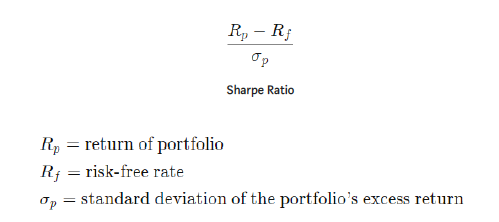

In order to minimize sharpe ratio for a given list of stocks, we will leverage on Sequential Least Squares Programming in Minimise function from Scipy library. We assume that shorting stock is not applicable in this portfolio.

In [18]:
#optimization
#create functions

def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

from scipy.optimize import minimize

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0,1),)*len(stocks_of_interest)

# Initial Guess (equal distribution)
init_guess= [1/len(stocks_of_interest)]*len(stocks_of_interest)

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)


In [19]:
#stock allocation
weight_result = pd.DataFrame(list(opt_results.x),columns=['Optimal Allocation'],index=stocks_of_interest)
weight_result

,Optimal Allocation
MSFT,0.264145
WMT,0.027506
JNJ,0.500590
INTC,0.058091
JPM,0.149668


In [20]:
#Optimal result
result = get_ret_vol_sr(opt_results.x)
print('Annualized return in this portfolio is {ret}'.format(ret=result[0]))
print('Volatility in this portfolio is {vol}'.format(vol=result[1]))
print('Sharpe ratio is {sr}'.format(sr=result[2]))

Annualized return in this portfolio is 0.19257348284274295
Volatility in this portfolio is 0.1315896633351948
Sharpe ratio is 1.4634392851375089


# Conclusion

In this jupyter notebook, we have explored ways to automatically optimize portfolio allocation usign the concept of Modern Portfolio Theory. Modern Portfolio Theory is by no man a fool-proof investment strategies but it aids in decision making process to come up with the right strategies to diversify portfolio. 